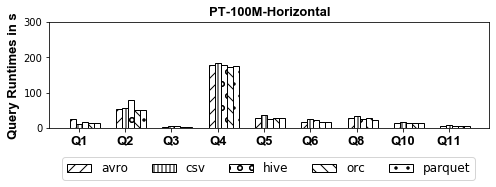

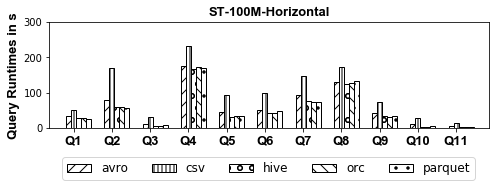

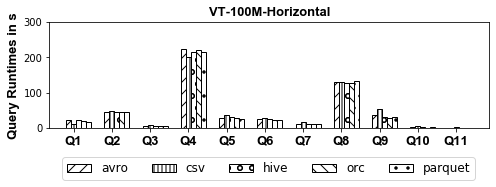

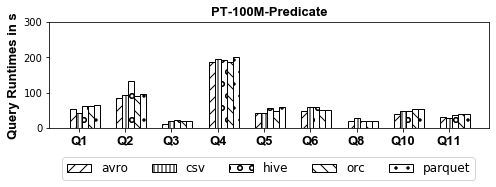

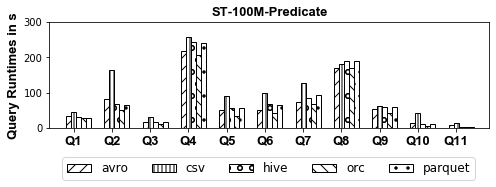

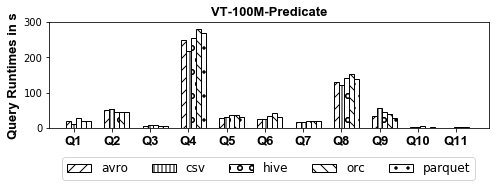

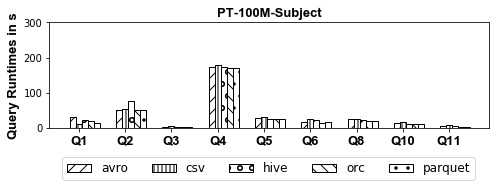

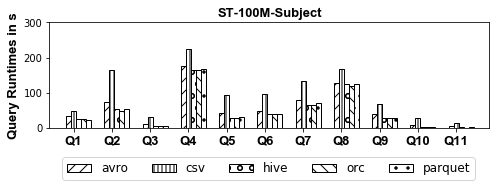

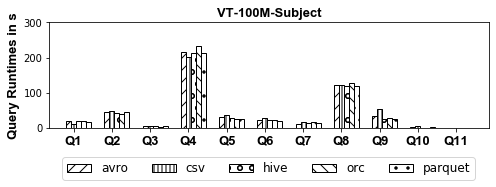

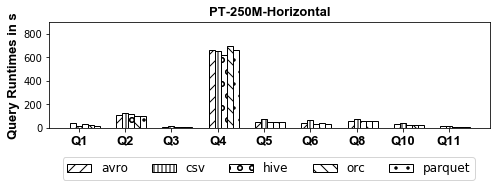

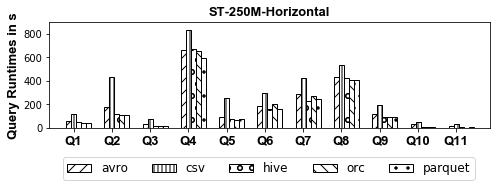

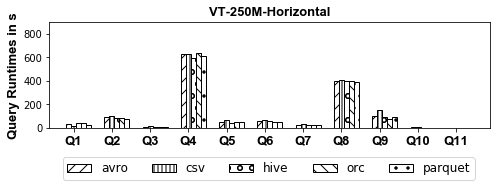

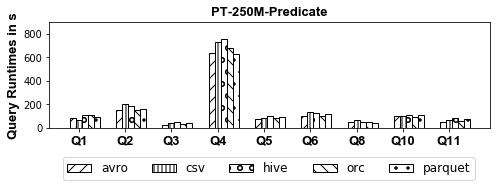

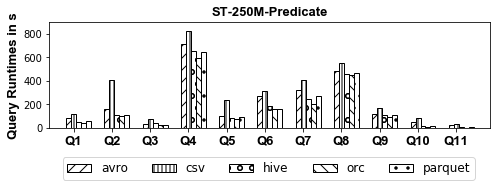

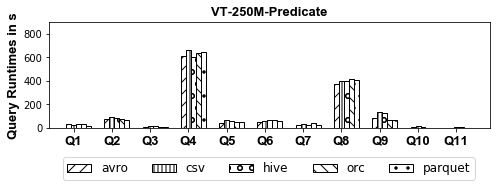

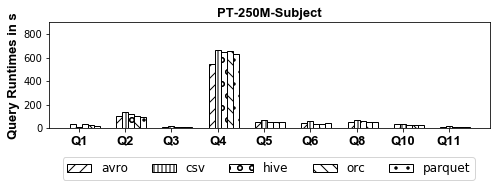

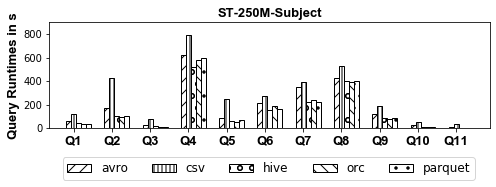

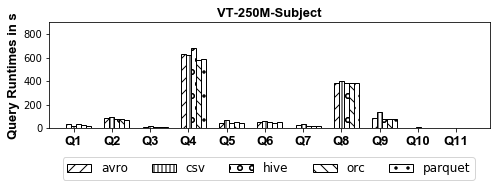

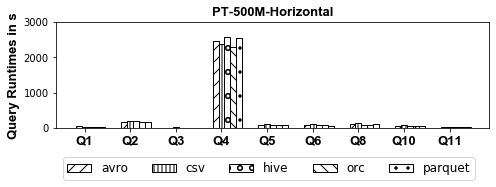

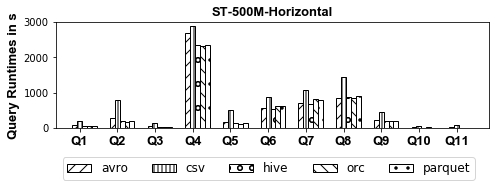

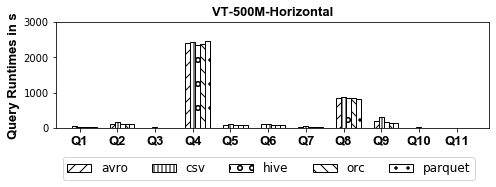

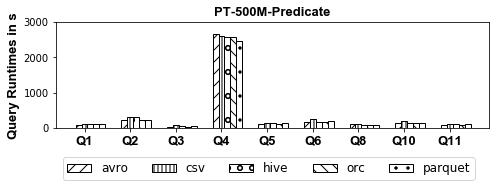

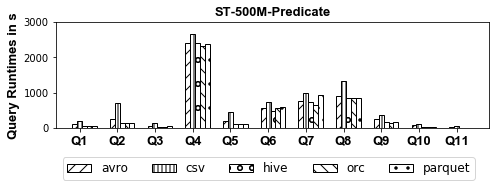

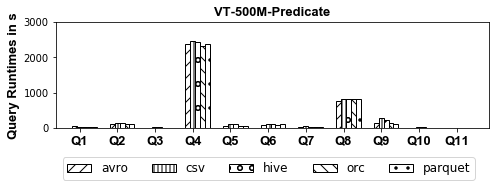

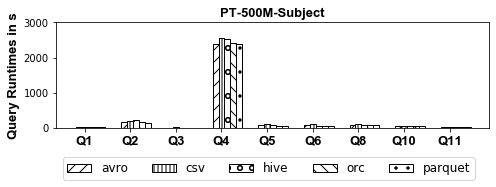

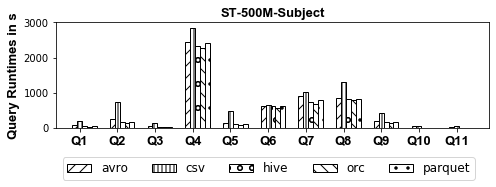

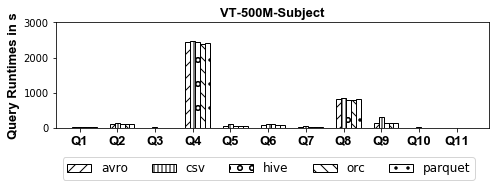

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

#parent folder of data files
path = 'C:\\Users\\Sadiq\\Desktop\\\sp2benchData\\logs'

#define query numbers if there will be grouping (long and short running queries), otherwise leave empty
# long_queries = [2, 4, 5, 6, 7, 8, 9]
long_queries = []

#create variables
all_data, long_data, short_data  = ([] for i in range(3))
dirs_list, file_sizes, filenames_list = ([] for i in range(3))
all_missed_queries = []

for filename in os.listdir(path):
    file_sizes.append(filename)

    
def read_files(path, parse = 0):
    
    global schemas, file_formats, length_of_queries
    
    #iterate on given path and read files
    for subdir, dirs, files in os.walk(path):
        
        dirs_list.append(dirs)
        for file in files:
            #full path of the file
            filepath = subdir + os.sep + file
            
            #append to all_data by averaging the values inside the file
            all_data.append(pd.read_csv(filepath, header = None).mean().values.tolist())                        
            
    file_formats = dirs_list[1]
    schemas = dirs_list[2]
    length_of_queries = len(all_data[0])
    
    
    # parse all data into long and short data frames
    if parse == 1:
        for i in range(len(all_data)):
            long_array = []
            short_array = []
            for j in range(len(all_data[i])):
                if all_data[i][j] != 0:
                    if (j+1) in long_queries:
                        long_array.append(all_data[i][j])
                    else:
                        short_array.append(all_data[i][j])
            long_data.append(long_array)       
            short_data.append(short_array) 
                
    #remove 0's and get indexes
    index, list_of_indexes, all_list_of_indexes = ([] for i in range(3))     
    for i in range(len(all_data)):
        list_of_indexes = []
        deleted_zeros = 0
        for j in range(len(all_data[i])):
            index = []                        
            if (all_data[i][j-deleted_zeros]) == 0:                
                all_data[i].pop(j-deleted_zeros)                
                index.append(i)
                index.append(j)  
                deleted_zeros = deleted_zeros + 1
                list_of_indexes.append(index)
                
        if len(list_of_indexes) == 0:
            all_list_of_indexes.append(0)
        else:                        
            all_list_of_indexes.append(list_of_indexes)
    
    #get all missed queries    
    missed_queries = []
    for s in range(len(file_sizes)):    
        for sc in range(len(schemas)):        
            
            missed_queries=[]
            if all_list_of_indexes[sc+(s*len(file_formats)*len(schemas))] != 0:
                for j in range(len(all_list_of_indexes[sc+(s*len(file_formats)*len(schemas))])):
                    missed_queries.append(all_list_of_indexes[sc+(s*len(file_formats)*len(schemas))][j][1])
                all_missed_queries.append(missed_queries)
            else:
                all_missed_queries.append(0)    


# get query names
all_labels, long_labels, short_labels = ([] for i in range(3))
def get_labels():    
    
    if not long_queries:
        
        for i in range(len(all_missed_queries)):
            labels = []
            for j in range(length_of_queries):                
                if all_missed_queries[i] == 0:
                    labels.append("Q" + str(j+1))
                elif j not in all_missed_queries[i]:                    
                    labels.append("Q"+str(j+1))            
            all_labels.append(labels)
    else:
        
        for i in range(len(all_missed_queries)):
            label_l = []   
            label_sh = []
            for j in range(length_of_queries):                
                                
                if all_missed_queries[i] == 0 and j+1 in long_queries:                    
                    label_l.append("Q" + str(j+1))
                    
                elif all_missed_queries[i] == 0 and j+1 not in long_queries:
                    label_sh.append("Q" + str(j+1))
                
                elif j not in all_missed_queries[i] and j+1 in long_queries:
                    label_l.append("Q" + str(j+1))
                
                elif j not in all_missed_queries[i] and j+1 not in long_queries:
                    label_sh.append("Q" + str(j+1))                                                                                
                        
            long_labels.append(label_l)
            short_labels.append(label_sh)
       
                   
def make_plot(data, query_labels, query_text):
    
    n_schemas = len(schemas)    
    width = 0.13     # the width of the bars 0.13    
    hatches = ['//', '|||', 'o', '\\\\', '.', 'x','O', '^', '*', '-']                                   
                                                   
    for size in range(len(file_sizes)):
        for s in range(n_schemas):

            fig, ax = plt.subplots(figsize=(7,2.85))   #figsize=(12,6)  #7,4                                    
            xs = []
            
            r1 = np.arange(len(query_labels[(size*n_schemas)+s]))    
            xs.append(r1)            
            xs.append([x + width for x in xs[0]])
            xs.append([x + width for x in xs[1]])
            xs.append([x + width for x in xs[2]])
            xs.append([x + width for x in xs[3]])
                                                
            for f in range(len(file_formats)):
                ax.bar(xs[f], data[s+(f*n_schemas)+(n_schemas*len(file_formats)*size)], width, label=file_formats[f], hatch=hatches[f], fill=False)

            ax.set_ylabel('Query Runtimes in s', fontname="Arial", fontsize=13, weight='bold')
            ax.set_title(schemas[s]+'-'+file_sizes[size], fontname="Arial", fontsize=13, weight='bold')        
            ax.set_xticks([r + width for r in range(len(r1))])            
            ax.set_xticklabels(query_labels[(size*n_schemas)+s], fontname="Arial", fontsize=13, weight='bold')            
            
            if not long_queries:
                ax.legend(bbox_to_anchor=(0.98, -0.22), ncol=len(file_formats), prop={'size': 12}) 
                fig.tight_layout()
            else:
                ax.legend(bbox_to_anchor=(1.025, -0.15), ncol=len(file_formats), prop={'size': 11.5})             
            
            #set scale of x and y axis
            if query_text == 'Short queries':
                if size < 3:
                    plt.axis([-0.5, len(r1), 0, 70])  
                elif size < 6:
                    plt.axis([-0.5, len(r1), 0, 120])  
                else:
                    plt.axis([-0.5, len(r1), 0, 220]) 
            else:
                if size < 3:
                    plt.axis([-0.5, len(r1), 0, 300])  
                elif size < 6:
                    plt.axis([-0.5, len(r1), 0, 900])  
                else:
                    plt.axis([-0.5, len(r1), 0, 3000]) 
                
                
            #save and show plots
            plot_path = path.replace('logs', 'plots')
            plt.savefig(plot_path + '\\'+file_sizes[size]+'\\'+schemas[s]+'-'+file_sizes[size]+' '+ query_text +'.png', bbox_inches='tight')            
            plt.show()

                                                
#plot all query results together
if not long_queries:
    read_files(path)
    get_labels()
    make_plot(all_data, all_labels, 'All queries')
#plot long and short query results separately
else:    
    read_files(path, 1)
    get_labels() 
    make_plot(long_data, long_labels, 'Long queries')
    make_plot(short_data, short_labels, 'Short queries')
